# Importing and splitting

In [ ]:
## Installing packages

In [ ]:
!pip install pandas==1.3.0

     |████████████████████████████████| 10.8 MB 4.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.0 which is incompatible.


In [ ]:
import pandas as pd
pd.__version__

'1.3.0'

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.4 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=0db9b3709c91eeb4e94e394af40909f565c057ac28aeb0f296021ef2aeb4f101
  Stored in directory: /tmp/pip-ephem-wheel-cache-u_iy_pae/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import en_core_web_lg
nlp = en_core_web_lg.load()

## Importing data
https://zenodo.org/record/4561253

Label: (1 = Fake, 0 = Real)
Switching values for classes to come in same order as previous datasets used
Label used post-import: 0 = Fake, 1 = Real


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('WELFake_Dataset_cleaned.csv', 
                   sep = ';', engine = 'python', encoding_errors = 'ignore')
data['body'] = data['title'].fillna('') + ' - ' + data['text'].fillna('')
data.label = abs(data.label - 1)

x = data.body
y = data.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

y_train = list(y_train)
y_test = list(y_test)


In [ ]:
print('Full dataset:')
share_fake = (y_train.count(0) + y_test.count(0)) / (len(y_train) + len(y_test))
print('{} entries, of which {:.0%} are fake'.format((len(y_train) + len(y_test)), share_fake))

print('Train:')
share_fake = y_train.count(0) / len(y_train)
print('{} entries, of which {:.0%} are fake'.format(len(y_train), share_fake))

print('Test:')
share_fake = y_test.count(0) / len(y_test)
print('{} entries, of which {:.0%} are fake'.format(len(y_test), share_fake))

Full dataset:
72134 entries, of which 51% are fake
Train:
50493 entries, of which 51% are fake
Test:
21641 entries, of which 51% are fake


# Plotting data

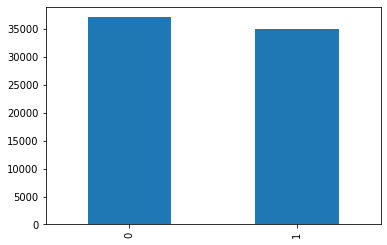

In [ ]:
import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind = 'bar')



# Naive Bayes

## Training and testing model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer(stop_words = 'english')
nb = MultinomialNB()

pipe_naive = Pipeline(steps = [
                               ('vec', tfidf),
                               ('nb', nb)
                               ])

model_naive = pipe_naive.fit(X = x_train, y = y_train)

In [ ]:
from sklearn.metrics import classification_report

y_pred_nb = model_naive.predict(x_test)

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11131
           1       0.87      0.87      0.87     10510

    accuracy                           0.87     21641
   macro avg       0.87      0.87      0.87     21641
weighted avg       0.87      0.87      0.87     21641



## Interpreting

### Creating feature lookup

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Generate total counts in training corpus
dt_matrix = tfidf.fit_transform(x_train)
tfidf_sum = dt_matrix.sum(axis = 0)
tfidf_sum = np.transpose(tfidf_sum).tolist()
tfidf_sum = [e[0] for e in tfidf_sum]

cvec = CountVectorizer(stop_words = 'english')
count_matrix = cvec.fit_transform(x_train)
c_sum = count_matrix.sum(axis = 0)
c_sum = np.transpose(c_sum).tolist()
c_sum = [e[0] for e in c_sum]


feature_names = tfidf.get_feature_names_out()


real_log_prob = nb.feature_log_prob_[1]
fake_log_prob = nb.feature_log_prob_[0]

# real - fake
# > 0 --> Important for real (Positive contribution to predicting OR)
# < 0 --> Important for fake
delta_log_prob = real_log_prob - fake_log_prob
delta_adjusted_tfidf = [d * t for (d, t) in zip(delta_log_prob, tfidf_sum)]
delta_adjusted_count = [d * c for (d, c) in zip(delta_log_prob, c_sum)]

# Converting log prob to normal prob
real_prob = np.exp(real_log_prob)
fake_prob = np.exp(fake_log_prob)
delta_prob = real_prob - fake_prob

# count = delta_adjusted_count,
d = dict(
    word = feature_names, 
    real = real_log_prob, 
    fake = fake_log_prob, 
    delta = delta_log_prob,
    importance_tfidf = delta_adjusted_tfidf,
    importance_count = delta_adjusted_count
    )

nb_lookup = pd.DataFrame(data = d)



In [ ]:
nb_lookup.sort_values(by = 'importance_count', ascending = False).iloc[:50]

,word,real,fake,delta,importance_tfidf,importance_count
155877,said,-5.805900,-7.020278,1.214378,2113.249006,199488.303753
120014,mr,-6.501381,-8.344160,1.842779,1427.524332,93174.584919
151427,reuters,-6.752596,-10.404903,3.652307,1948.142552,78082.669572
182462,trumps,-7.160686,-8.424605,1.263919,559.332607,24114.315874
123983,new,-6.928168,-7.334097,0.405929,294.704906,22738.527591
85256,house,-6.901058,-7.590313,0.689255,463.499749,22392.522369
169146,states,-7.070092,-7.647862,0.577770,340.846475,21459.534233
169076,state,-6.941765,-7.419737,0.477972,332.800806,20847.701353
185899,united,-7.149787,-7.852217,0.702430,366.422655,20828.453177
76645,government,-7.095374,-7.683032,0.587658,336.800247,20181.351620


### Printing individual articles (Interesting, not part of analysis)

In [ ]:
x_train_transformed = tfidf.fit_transform(x_train)

probabilities = nb.predict_proba(x_train_transformed)
probs = [
         [p[0] for p in probabilities],
         [p[1] for p in probabilities]
]

delta_prob = [p1 - p0 for (p0, p1) in zip(probs[0], probs[1])]

feature_names = tfidf.get_feature_names_out()

d = dict(
    text = x_train,
    gold_label = y_train,
    prob_real = probs[1],
    prob_fake = probs[0],
    prob_delta = delta_prob
)

nb_prob_lookup = pd.DataFrame(data = d)



In [ ]:
def add_new_lines(s, width = 75):
  tmp = list(s)
  index = 0
  counter = 0
  for c in s:
    if counter > width and c == ' ':
      tmp[index] = '\n'
      counter = 0
    else:
      counter = counter + 1
    index = index + 1
  return ''.join(tmp)

test = add_new_lines('This would select the first two rows of the data frame, then return the rows out of the first two rows that have a value for the col3 equal to 7. Point being you want to use iterrows only in very very specific situations. Otherwise, the solution can be vectorized.')

print(test)

This would select the first two rows of the data frame, then return the rows
out of the first two rows that have a value for the col3 equal to 7. Point being
you want to use iterrows only in very very specific situations. Otherwise, the
solution can be vectorized.


In [ ]:
def important_words(text, real = True, n = 10, use_ngrams = False):
  words = text.split(' ')

  if use_ngrams:
    tmpvec = CountVectorizer(stop_words = 'english', ngram_range = (2,3))
    tmpvec.fit_transform([text])
    words = list(tmpvec.get_feature_names_out())

  filtered_df = nb_lookup[nb_lookup['word'].isin(words)]
  if real:
    top_n = filtered_df.nlargest(n, 'delta')
  else:
    top_n = filtered_df.nsmallest(n, 'delta')

  features = list(top_n['word'])
  deltas = list(top_n['delta'])
  p_real = list(top_n['real'])
  p_fake = list(top_n['fake'])

  counts = []
  for word in features:
    counts.append(words.count(word))

  retval = list(zip(features, deltas, p_real, p_fake, counts))

  return sorted(retval, key = lambda e : e[1], reverse = real)


In [ ]:
import math

# Prints nicely, used in explain_predictions
def get_print_words(zipped_list):
  retval = 'Word' + ' '*17 + 'Count    P(Real)  P(Fake)  Delta'
  for word, delta, p_real, p_fake, count in zipped_list:
    retval = retval + '\n{:20} {:<2}      {: .2%}   {: .2%}   {: .2%}'.format(word, count, p_real, p_fake, delta)
  return retval

# Prints predictions showing which words are most important
def explain_predictions(percentile, credible = True, int_labels = False, n = 10):
  start_pos = math.ceil(percentile * len(nb_prob_lookup))
  end_pos = start_pos + n


  for i, row in nb_prob_lookup.sort_values(by = ['prob_delta'], ascending = not credible).iloc[start_pos:end_pos].iterrows():
    
    gold_label = row['gold_label']
    if int_labels:
      gold_label = 'Real' if gold_label == 1 else 'Fake'

    print('\n\n==============================================  Row {}  =============================================='.format(i))
    print('Gold label: ' + gold_label)
    print('P(Real) = {:.0%}, P(Fake) = {:.0%}'.format(row['prob_real'], row['prob_fake']))
    print('===   Text    === \n' + add_new_lines(row['text'], width = 150))
    print('\n=== Top words contributing to P(Real)  ===')
    print(get_print_words(important_words(row['text'], real = True)))
    print('\n=== Top words contributing to P(False) ===')
    print(get_print_words(important_words(row['text'], real = False)))
  

In [ ]:
explain_predictions(0.4, int_labels = True)



==============================================  Row 442  ==============================================
Gold label: Real
P(Real) = 74%, P(Fake) = 26%
===   Text    === 
Man Sentenced to 12 Years in Beating Death of Transgender Woman - The New York Times - A Brooklyn man who beat a transgender woman to death after he had
started flirting with her was sentenced to 12 years in prison on Tuesday, a penalty the victims family said was too light. The man, James Dixon, 25, pleaded
guilty to manslaughter this month in State Supreme Court in Manhattan, admitting he attacked the woman, Islan Nettles, on a street in Harlem just after
midnight on Aug. 17, 2013, knocking her to the pavement with a punch, then hitting her again as she lay on the sidewalk. Ms. Nettles, 21, an assistant at
a fashion company, died five days later of head injuries, prompting vigils and protests by transgender people who said her death was emblematic of the violence
they often face because of their sexual identity. Whi

### Creating rule clusters

In [ ]:
# Idea: Cluster the embedding of the top & bottom 100 words, interpret categories

# Only use words where abs(delta) > x?
real_words = nb_lookup.sort_values(by = 'importance_count', ascending = False).iloc[:200].word.values
fake_words = nb_lookup.sort_values(by = 'importance_count', ascending = True).iloc[:200].word.values



real_vectors = [nlp.vocab.get_vector(word) for word in real_words]
fake_vectors = [nlp.vocab.get_vector(word) for word in fake_words]




Text(0.5, 1.0, 'Real vectors')

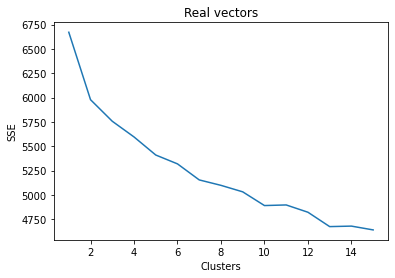

In [ ]:
from sklearn.cluster import KMeans

sse = {}
for n in range(1, 16):
  kmeans = KMeans(n_clusters = n, random_state = 0).fit(real_vectors)
  sse[n] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('Real vectors')




Text(0.5, 1.0, 'Fake vectors')

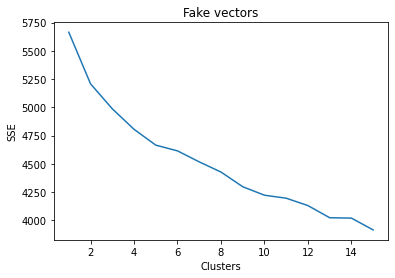

In [ ]:
sse = {}
for n in range(1, 16):
  kmeans = KMeans(n_clusters = n, random_state = 0).fit(fake_vectors)
  sse[n] = kmeans.inertia_

plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('Fake vectors')




In [ ]:
kmeans_real = KMeans(n_clusters = 7, random_state = 0).fit(real_vectors)
kmeans_fake = KMeans(n_clusters = 5, random_state = 0).fit(fake_vectors)



In [ ]:
real_clusters = nb_lookup.sort_values(by = 'importance_count', ascending = False).iloc[:200]
real_clusters['cluster'] = kmeans_real.labels_
real_clusters['label'] = [1] * len(kmeans_real.labels_)

fake_clusters = nb_lookup.sort_values(by = 'importance_count', ascending = True).iloc[:200]
fake_clusters['cluster'] = kmeans_fake.labels_
fake_clusters['label'] = [0] * len(kmeans_fake.labels_)

rule_lookup = pd.concat([real_clusters, fake_clusters])

In [ ]:
# Testing the dataframe

rule_lookup[(rule_lookup.cluster.isin([1,2]) & (rule_lookup.label == 0)) | (rule_lookup.cluster.isin([3]) & (rule_lookup.label == 1))]

,word,real,fake,delta,importance_tfidf,importance_count,cluster,label
85256,house,-6.901058,-7.590313,0.689255,463.499749,22392.522369,3,1
185899,united,-7.149787,-7.852217,0.702430,366.422655,20828.453177,3,1
126300,north,-7.340915,-8.439673,1.098758,421.751839,15683.666677,3,1
167029,south,-7.885429,-8.917726,1.032296,232.953829,9281.375774,3,1
148955,region,-8.296871,-9.596663,1.299792,181.467077,6262.398183,3,1
...,...,...,...,...,...,...,...,...
178116,thought,-9.033642,-8.560650,-0.472992,-64.524648,-2603.346379,1,0
91402,investigation,-8.187551,-7.936728,-0.250823,-70.501663,-2598.025013,1,0
10177,absolutely,-9.757572,-8.788172,-0.969400,-88.825690,-2586.359912,1,0
95799,js,-12.944291,-9.339105,-3.605186,-137.476189,-2541.655872,2,0


# Rule testing

## Creating the predictor

### Predictor

In [ ]:
import random

class RulePredictor:

  def __init__(self, lookup_df):
    self.lookup_df = lookup_df

  # Real word --> Vote + 1
  # Fake word --> Vote - 1
  # If vote = 0 in the end, predict by chance
  def predict(self, text):
    text = text.lower()
    vote = 0
    for i, row in self.lookup_df.iterrows():
      if row['word'] in text:
        vote = vote + 1 if row['label'] == 1 else vote - 1
    
    if vote == 0:
      return int(random.random() > 0.5)
    return int(vote > 0)

  


### Helper functions

In [ ]:
import time
def format_time(seconds):
  seconds = int(seconds)
  m, s = divmod(seconds, 60)
  h, m = divmod(m, 60)
  return('{:d}:{:02d}:{:02d}'.format(h, m, s))

def print_progress(start, it, total_its):
  elapsed_time = time.time() - start
  done = it / total_its
  remaining = format_time(elapsed_time / done - elapsed_time)
  
  output = '\n{} iterations of {} completed ({:.0%})'.format(
      it, total_its, done
      )
  output = output + ' in ' + format_time(elapsed_time)
  output = output + '\nEstimated time left: ' + remaining
  print(output)

## 1-combinations
One real and one fake, all combinations
Run four times over different subsamples

In [ ]:
from sklearn.metrics import f1_score
from itertools import product
import random

real = [0,1,2,3,4,5,6]
fake = [0,1,2,3,4]

one_combs = list(product(real, fake))

f1s = []

total_iterations = len(one_combs) * 4
current_iteration = 0
start = time.time()
for i in range(4):
  mini = list(zip(x_test, y_test))
  random.seed(i)
  mini = random.sample(mini, 1000)
  x_mini, y_mini = zip(*mini)

  f1 = []
  for r, f in one_combs:

    tmp = rule_lookup[
                    (rule_lookup.cluster.isin([f]) & (rule_lookup.label == 0)) | 
                    (rule_lookup.cluster.isin([r]) & (rule_lookup.label == 1))
                    ]

    rule_predictor = RulePredictor(tmp)

    rule_preds = []
    for text in x_mini:
      rule_preds.append(rule_predictor.predict(text))

    f1.append(f1_score(y_mini, rule_preds, average = 'weighted'))
    current_iteration = current_iteration + 1
    if current_iteration % 10 == 0:
      print_progress(start, current_iteration, total_iterations)
  f1s.append(f1)





10 iterations of 140 completed (7%) in 0:00:44
Estimated time left: 0:09:38

20 iterations of 140 completed (14%) in 0:01:17
Estimated time left: 0:07:45

30 iterations of 140 completed (21%) in 0:01:54
Estimated time left: 0:06:59

40 iterations of 140 completed (29%) in 0:02:33
Estimated time left: 0:06:24

50 iterations of 140 completed (36%) in 0:03:18
Estimated time left: 0:05:58

60 iterations of 140 completed (43%) in 0:03:51
Estimated time left: 0:05:09

70 iterations of 140 completed (50%) in 0:04:33
Estimated time left: 0:04:33

80 iterations of 140 completed (57%) in 0:05:16
Estimated time left: 0:03:57

90 iterations of 140 completed (64%) in 0:05:49
Estimated time left: 0:03:13

100 iterations of 140 completed (71%) in 0:06:26
Estimated time left: 0:02:34

110 iterations of 140 completed (79%) in 0:07:06
Estimated time left: 0:01:56

120 iterations of 140 completed (86%) in 0:07:52
Estimated time left: 0:01:18

130 iterations of 140 completed (93%) in 0:08:25
Estimated ti

In [ ]:
f1_avg = [(e1 + e2 + e3 + e4) / 4 for (e1, e2, e3, e4) in zip(f1s[0], f1s[1], f1s[2], f1s[3])]

res = sorted(zip(one_combs, f1_avg), key = lambda x : x[1], reverse = True)
for r in res:
  print(r)

((6, 2), 0.7638558942982969)
((4, 2), 0.7407355946756246)
((2, 2), 0.7245491808041193)
((1, 2), 0.7215081117121084)
((4, 3), 0.6853140880978399)
((4, 0), 0.6763912255909366)
((5, 0), 0.673651620294994)
((5, 4), 0.644554742191797)
((2, 3), 0.6442302710501877)
((6, 3), 0.6424665204267201)
((5, 3), 0.6345400465549502)
((2, 0), 0.632489047573812)
((6, 0), 0.6288345039784855)
((4, 4), 0.6229387582570257)
((5, 2), 0.6141349771290417)
((0, 0), 0.6071541420465895)
((1, 3), 0.6011176352667829)
((3, 0), 0.5962459230747025)
((1, 0), 0.5897882791491394)
((6, 4), 0.5737150472808232)
((0, 3), 0.5721207066630454)
((0, 2), 0.569906997916853)
((3, 3), 0.5683637187362874)
((0, 4), 0.5644063719527765)
((3, 4), 0.5599337986233169)
((2, 4), 0.5573324647436537)
((1, 4), 0.5461355699084629)
((3, 2), 0.5290796033324345)
((1, 1), 0.4711312362065188)
((6, 1), 0.40733581712084865)
((4, 1), 0.3453320434733955)
((5, 1), 0.3442539379972307)
((2, 1), 0.34036859700734046)
((0, 1), 0.3395048995422334)
((3, 1), 0.33732

## 2-combinations
Two real, two fake - all combinations
Four subsets

In [ ]:
from itertools import combinations

real = [0,1,2,3,4,5,6]
fake = [0,1,2,3,4]

real_combs = [list(comb) for comb in combinations(real, 2)]
fake_combs = [list(comb) for comb in combinations(fake, 2)]

two_combs = list(product(real_combs, fake_combs))

f1s_2comb = []
total_iterations = len(two_combs) * 4
current_iteration = 0
start = time.time()
for i in range(4):
  mini = list(zip(x_test, y_test))
  random.seed(i)
  mini = random.sample(mini, 1000)
  x_mini, y_mini = zip(*mini)

  f1 = []
  for r, f in two_combs:
    tmp = rule_lookup[
                    (rule_lookup.cluster.isin(f) & (rule_lookup.label == 0)) | 
                    (rule_lookup.cluster.isin(r) & (rule_lookup.label == 1))
                    ]

    rule_predictor = RulePredictor(tmp)

    rule_preds = []
    for text in x_mini:
      rule_preds.append(rule_predictor.predict(text))

    f1.append(f1_score(y_mini, rule_preds, average = 'weighted'))
    current_iteration = current_iteration + 1
    if current_iteration % 10 == 0:
      print_progress(start, current_iteration, total_iterations)
  f1s_2comb.append(f1)



10 iterations of 840 completed (1%) in 0:01:25
Estimated time left: 1:58:05

20 iterations of 840 completed (2%) in 0:02:32
Estimated time left: 1:43:52

30 iterations of 840 completed (4%) in 0:03:32
Estimated time left: 1:35:41

40 iterations of 840 completed (5%) in 0:04:39
Estimated time left: 1:33:07

50 iterations of 840 completed (6%) in 0:05:48
Estimated time left: 1:31:42

60 iterations of 840 completed (7%) in 0:07:05
Estimated time left: 1:32:05

70 iterations of 840 completed (8%) in 0:08:32
Estimated time left: 1:33:54

80 iterations of 840 completed (10%) in 0:09:53
Estimated time left: 1:34:02

90 iterations of 840 completed (11%) in 0:11:22
Estimated time left: 1:34:46

100 iterations of 840 completed (12%) in 0:12:52
Estimated time left: 1:35:15

110 iterations of 840 completed (13%) in 0:14:30
Estimated time left: 1:36:18

120 iterations of 840 completed (14%) in 0:15:32
Estimated time left: 1:33:17

130 iterations of 840 completed (15%) in 0:16:42
Estimated time lef

In [ ]:
f1s2_avg = [(e1 + e2 + e3 + e4) / 4 for (e1, e2, e3, e4) in zip(f1s_2comb[0], f1s_2comb[1], f1s_2comb[2], f1s_2comb[3])]

res = sorted(zip(two_combs, f1s2_avg), key = lambda x : x[1], reverse = True)
for r in res:
  print(r)

(([5, 6], [0, 2]), 0.8046060783854242)
(([5, 6], [2, 4]), 0.7994727761697543)
(([5, 6], [2, 3]), 0.7986885853130394)
(([4, 6], [0, 2]), 0.787823507122177)
(([3, 6], [0, 2]), 0.7868604341599276)
(([4, 6], [2, 3]), 0.7866098008106941)
(([2, 4], [2, 3]), 0.7851811091829518)
(([0, 6], [0, 2]), 0.7851109501812259)
(([2, 4], [2, 4]), 0.7788873177132518)
(([3, 6], [2, 4]), 0.7779641914415792)
(([3, 6], [2, 3]), 0.7774284528250021)
(([1, 5], [0, 2]), 0.7760931320398206)
(([1, 5], [2, 3]), 0.7751281134886947)
(([0, 6], [2, 3]), 0.7736303694965752)
(([2, 6], [2, 3]), 0.7731878733442064)
(([2, 4], [0, 2]), 0.7715386985595127)
(([4, 5], [0, 4]), 0.7679357722779374)
(([4, 6], [2, 4]), 0.767617503193998)
(([0, 6], [2, 4]), 0.7667213786763936)
(([2, 6], [0, 2]), 0.7649524427931221)
(([1, 3], [2, 3]), 0.7643443077713558)
(([4, 5], [2, 4]), 0.7613637783494422)
(([2, 5], [2, 4]), 0.7610047606408675)
(([1, 5], [2, 4]), 0.7600798378200465)
(([5, 6], [0, 3]), 0.7580917893298098)
(([4, 5], [3, 4]), 0.754760

## Individual clusters
Real & fake independantly

In [ ]:
from sklearn.metrics import f1_score
import random

real = [0,1,2,3,4,5,6]
fake = [0,1,2,3,4]

f1s_real = []
f1s_fake = []
for i in range(4):
  mini = list(zip(x_test, y_test))
  random.seed(i)
  mini = random.sample(mini, 1000)
  x_mini, y_mini = zip(*mini)

  f1 = []
  for r in real:

    tmp = rule_lookup[ 
                    (rule_lookup.cluster.isin([r]) & (rule_lookup.label == 1))
                    ]

    rule_predictor = RulePredictor(tmp)

    rule_preds = []
    for text in x_mini:
      rule_preds.append(rule_predictor.predict(text))

    f1.append(f1_score(y_mini, rule_preds, average = 'weighted'))
  f1s_real.append(f1)

  f1 = []
  for f in fake:

    tmp = rule_lookup[ 
                    (rule_lookup.cluster.isin([f]) & (rule_lookup.label == 0))
                    ]

    rule_predictor = RulePredictor(tmp)

    rule_preds = []
    for text in x_mini:
      rule_preds.append(rule_predictor.predict(text))

    f1.append(f1_score(y_mini, rule_preds, average = 'weighted'))
  f1s_fake.append(f1)




In [ ]:
f1_r_avg = [(e1 + e2 + e3 + e4) / 4 for (e1, e2, e3, e4) in zip(f1s_real[0], f1s_real[1], f1s_real[2], f1s_real[3])]
f1_f_avg = [(e1 + e2 + e3 + e4) / 4 for (e1, e2, e3, e4) in zip(f1s_fake[0], f1s_fake[1], f1s_fake[2], f1s_fake[3])]

res_r = sorted(zip(real, f1_r_avg), key = lambda x : x[1], reverse = True)
res_f = sorted(zip(fake, f1_f_avg), key = lambda x : x[1], reverse = True)

print('=========== Real results:')
for r in res_r:
  print(r)

print('=========== Fake results:')
for r in res_f:
  print(r)

=========== Real results:
(5, 0.5761713421596661)
(3, 0.5134456931231718)
(0, 0.48407543491916283)
(2, 0.4015141990653033)
(1, 0.3921649277226231)
(6, 0.3888663117808071)
(4, 0.37452454118047507)
=========== Fake results:
(0, 0.3928577213699439)
(3, 0.3828577797055899)
(2, 0.365429135055805)
(1, 0.33500568670661457)
(4, 0.333534047192369)


## 1- and 2-combs


In [ ]:
from itertools import combinations
from itertools import product

real = [0,1,2,3,4,5,6]
fake = [0,1,2,3,4]

real_2combs = [list(comb) for comb in combinations(real, 2)]
fake_2combs = [list(comb) for comb in combinations(fake, 2)]

real_list = [[e] for e in real]
fake_list = [[e] for e in fake]

tmp = list(product(real_list, fake_2combs))
one_two_combs = tmp + list(product(real_2combs, fake_list))

In [ ]:
from sklearn.metrics import f1_score

f1s_2_1_comb = []
total_iterations = len(one_two_combs) * 4
current_iteration = 0
start = time.time()

for i in range(4):
  mini = list(zip(x_test, y_test))
  random.seed(i)
  mini = random.sample(mini, 1000)
  x_mini, y_mini = zip(*mini)

  f1 = []
  for r, f in one_two_combs:
    tmp = rule_lookup[
                    (rule_lookup.cluster.isin(f) & (rule_lookup.label == 0)) | 
                    (rule_lookup.cluster.isin(r) & (rule_lookup.label == 1))
                    ]

    rule_predictor = RulePredictor(tmp)

    rule_preds = []
    for text in x_mini:
      rule_preds.append(rule_predictor.predict(text))

    f1.append(f1_score(y_mini, rule_preds, average = 'weighted'))
    current_iteration = current_iteration + 1
    if current_iteration % 10 == 0:
      print_progress(start, current_iteration, total_iterations)
  f1s_2_1_comb.append(f1)



10 iterations of 700 completed (1%) in 0:00:54
Estimated time left: 1:02:10

20 iterations of 700 completed (3%) in 0:02:09
Estimated time left: 1:13:23

30 iterations of 700 completed (4%) in 0:03:05
Estimated time left: 1:09:05

40 iterations of 700 completed (6%) in 0:03:55
Estimated time left: 1:04:52

50 iterations of 700 completed (7%) in 0:04:53
Estimated time left: 1:03:29

60 iterations of 700 completed (9%) in 0:05:51
Estimated time left: 1:02:32

70 iterations of 700 completed (10%) in 0:06:56
Estimated time left: 1:02:32

80 iterations of 700 completed (11%) in 0:07:50
Estimated time left: 1:00:46

90 iterations of 700 completed (13%) in 0:08:32
Estimated time left: 0:57:51

100 iterations of 700 completed (14%) in 0:09:23
Estimated time left: 0:56:18

110 iterations of 700 completed (16%) in 0:10:27
Estimated time left: 0:56:03

120 iterations of 700 completed (17%) in 0:11:36
Estimated time left: 0:56:07

130 iterations of 700 completed (19%) in 0:12:35
Estimated time le

In [ ]:
f1s2_avg = [(e1 + e2 + e3 + e4) / 4 for (e1, e2, e3, e4) in zip(f1s_2_1_comb[0], f1s_2_1_comb[1], f1s_2_1_comb[2], f1s_2_1_comb[3])]

res = sorted(zip(one_two_combs, f1s2_avg), key = lambda x : x[1], reverse = True)
for r in res:
  print(r)

(([4, 5], [2]), 0.7886815747331322)
(([2, 5], [2]), 0.7774014929034592)
(([3, 4], [2]), 0.7754042702297358)
(([6], [0, 2]), 0.7657438080462311)
(([0, 4], [2]), 0.7640082003438847)
(([6], [2, 4]), 0.7614366050637975)
(([1], [2, 3]), 0.7560076999833366)
(([5, 6], [2]), 0.7534896878738779)
(([6], [2, 3]), 0.747540577514473)
(([1], [0, 2]), 0.7461514795643013)
(([2, 3], [2]), 0.7456423131598586)
(([6], [0, 3]), 0.7432267227382369)
(([0, 5], [2]), 0.7417268811487217)
(([0, 5], [0]), 0.7413011603166618)
(([3, 6], [2]), 0.7383662099183572)
(([0, 2], [2]), 0.7376076696297491)
(([6], [0, 4]), 0.7359850047779095)
(([3, 5], [4]), 0.7292613709391842)
(([0, 6], [2]), 0.7283205844456688)
(([1], [2, 4]), 0.7261998590329922)
(([6], [3, 4]), 0.7243620442948977)
(([3, 5], [2]), 0.7154592330293915)
(([2, 4], [2]), 0.7122050379134572)
(([1, 6], [1]), 0.7118033474732595)
(([1, 5], [2]), 0.711360265500856)
(([3, 5], [0]), 0.7107208330393714)
(([1], [0, 3]), 0.7091733087422274)
(([3, 5], [3]), 0.706978608191

# Interpreting clusters

## Seeing the interia for each cluster

In [ ]:
kmeans_r = KMeans(n_clusters = 7, random_state = 0)
kmeans_f = KMeans(n_clusters = 5, random_state = 0)
distances_r = kmeans_r.fit_transform(real_vectors)
distances_f = kmeans_f.fit_transform(fake_vectors)




In [ ]:
r_clusters = list(set(kmeans_r.labels_))
f_clusters = list(set(kmeans_f.labels_))

variance_r = dict.fromkeys(r_clusters, 0)
i = 0
for label in kmeans_r.labels_:
    variance_r[label] = variance_r[label] + distances_r[i][label]
    i = i + 1

variance_f = dict.fromkeys(f_clusters, 0)
i = 0
for label in kmeans_f.labels_:
    variance_f[label] = variance_f[label] + distances_f[i][label]
    i = i + 1

In [ ]:


print('Real clusters:')
for k, v in variance_r.items():
  print('Cluster {}: {:>7}'.format(k, round(v, 2)))

print('\nFake clusters:')
for k, v in variance_f.items():
  print('Cluster {}: {:>7}'.format(k, round(v, 2)))

Real clusters:
Cluster 0:   87.23
Cluster 1:  301.99
Cluster 2:  101.98
Cluster 3:   51.29
Cluster 4:  122.46
Cluster 5:  138.76
Cluster 6:  198.73

Fake clusters:
Cluster 0:   122.3
Cluster 1:  460.64
Cluster 2:  210.41
Cluster 3:  136.69
Cluster 4:   10.91


## Studying clusters

In [ ]:
# Study the clusters!
tmp = rule_lookup[((rule_lookup.cluster == 6) & (rule_lookup.label == 1))].sort_values(by = 'importance_count', ascending = False)
print(len(tmp))
print(tmp)

40
                   word      real       fake  ...  importance_count  cluster  label
155877             said -5.805900  -7.020278  ...     199488.303753        6      1
116800         minister -7.457444  -9.272784  ...      18269.579309        6      1
179627             told -7.337762  -7.881266  ...      14260.477397        6      1
128650        officials -7.558363  -8.423673  ...      14231.740542        6      1
141242        president -6.733552  -6.951393  ...      13667.747668        6      1
45170             court -7.352300  -8.137441  ...      13524.827929        6      1
169119        statement -7.599916  -8.461944  ...      11039.994586        6      1
167930        spokesman -7.948490  -9.750158  ...      10175.818920        6      1
133925            party -7.308720  -7.684401  ...       9167.009072        6      1
174376            talks -7.981968  -9.844971  ...       8914.469658        6      1
104040          leaders -7.899927  -8.889643  ...       8772.836339      